# Projeto 3
***

### Análise de projetos no Kickstarter

As análises feitas a seguir foram feitas a partir do seguinte dataset:

- https://www.kaggle.com/kemical/kickstarter-projects

**Objetivo deste estudo:** Descobrir a probabilidade de sucesso de um projeto no kickstarter.

In [1]:
#importando bibliotecas:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm, probplot
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

## Análise Exploratória:


In [2]:
#Importado o arquivo:
df = pd.read_csv('ks-projects-201612.csv', encoding='iso-8859-1', low_memory=False)

In [3]:
#Decobrindo o tamanho do dataset:
linhas,colunas = df.shape
print("O Dataframe tem {0} linhas por {1} colunas.".format(linhas,colunas))

O Dataframe tem 323750 linhas por 17 colunas.



#### Preparando o dataframe para ser analisado:

Vamos limpar o database para nao ter complicacoes mais tarde  na hora de fazer as análises.

In [4]:
#Removendo os espaços em branco dos nomes das colunas:
df.columns = [i.strip() for i in df.columns.tolist()]

In [5]:
#Procurando por valores nulos que podem causar problemas posteriores:
print('Valores nulos na coluna "name":', df["name"].isnull().any(),
      '\nValores nulos na coluna "category":', df["category"].isnull().any(),
      '\nValores nulos na coluna "usd pledged":', df["usd pledged"].isnull().any())

Valores nulos na coluna "name": True 
Valores nulos na coluna "category": True 
Valores nulos na coluna "usd pledged": True


In [6]:
#Removendo os valores nulos:
df = df.dropna( axis=0, subset=['name', 'category','usd pledged'])
df.head(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN


### Análise das colunas do database:
O dataframe possui 4 colunas sem nome, vamos checar se elas tem algum conteudo:

In [7]:
#Descobrindo quantidade de linhas nulas nas colunas sem nome:
Unnamed_Colums_Null = [df['Unnamed: 13'].isna().sum(),df['Unnamed: 14'].isna().sum(),df['Unnamed: 15'].isna().sum(),df['Unnamed: 16'].isna().sum()]
Unnamed_Colums_Not_Null = [df['Unnamed: 13'].value_counts().sum(),df['Unnamed: 14'].value_counts().sum(),df['Unnamed: 15'].value_counts().sum(),df['Unnamed: 16'].value_counts().sum()]
Valores13 = 100-(df['Unnamed: 13'].value_counts().sum()/df['Unnamed: 13'].isna().sum()*100)
Valores14 = 100-(df['Unnamed: 14'].value_counts().sum()/df['Unnamed: 14'].isna().sum()*100)
Valores15 = 100-(df['Unnamed: 15'].value_counts().sum()/df['Unnamed: 15'].isna().sum()*100)
Valores16 = 100-(df['Unnamed: 16'].value_counts().sum()/df['Unnamed: 16'].isna().sum()*100)
print('A quantidade de valores nulos na coluna 14 é: {:.4f}%'.format(Valores13),'\nA quantidade de valores nulos na coluna 15 é: {:.4f}%'.format(Valores14),'\nA quantidade de valores nulos na coluna 16 é: {:.4f}%'.format(Valores15),'\nA quantidade de valores nulos na coluna 17 é: {:.4f}%'.format(Valores16))

A quantidade de valores nulos na coluna 14 é: 99.8058% 
A quantidade de valores nulos na coluna 15 é: 99.9962% 
A quantidade de valores nulos na coluna 16 é: 99.9987% 
A quantidade de valores nulos na coluna 17 é: 99.9997%


In [8]:
#Removendo as ultimas 4 colunas (com valores nulos):
df = df.iloc[:,:-4]

In [9]:
df.head(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220


***

### Transformando categorias qualiativas em quantiativas:

O método usado para efetuar essa conversão é chamado de **One Hot Encoding**, que transforma variaveis categóricas em vetores binarios. Tal método transforma todas as variaveis em 0 menos a do item analisado, desse modo permitindo que sejam feitam análises em cima desse dados.
<br>
<br>

In [10]:
#Função para chamar o get_dummies e remover a coluna base:
def dummify(data, column_name):
    df1 = data.copy()
    df2 = pd.concat([df1.drop(column_name, axis=1), pd.get_dummies(data[column_name], prefix=column_name)], axis=1)
    return df2

In [11]:
#Transformando "category" em uma variável quantitativa:
DF = dummify(df, "category")

In [12]:
#Transformando "currency" em uma variável quantitativa:
df[~df.currency.str.contains('\A[a-z]{3}\Z', case=False)].currency.value_counts();
replace = df[~df.currency.str.contains('^[a-z]{3}$', case=False)].currency.unique().tolist()
df.loc[:,'currency'] = df.currency.replace(to_replace=replace, value='Não especificado')

DF = dummify(DF, "currency")

In [13]:
#Transformando "country" em uma variável quantitativa:
df[~df.country.str.contains('^[A-Z]{2}$', case=False)].country.value_counts()
replace = df[~df.country.str.contains('^[A-Z]{2}$', case=False)].country.unique().tolist()
df.loc[:,'country'] = df.country.replace(to_replace=replace, value='Não especificado')

DF = dummify(DF, "country")

In [14]:
#Transformando "state" em uma variável quantitativa:
DF1 = dummify(df, "state")
DF1 = DF1.iloc[:,414:]
ddf = DF.join(DF1, how="inner")
ddf.drop(columns=['state', 'country_failed','country_successful'], inplace=True)
ddf = ddf.iloc[:,9:]
ddf = ddf.join((df['goal'],df['backers'],df['pledged']), how="inner")

Foi criado um dataframe novo para ser usado posterioremente pelos modelos de predição, todas variáveis categoricas foram convertidas em quantitativas. Essas foram adicionadas no final de cada dataframe por meio de novas colunas.

***
### Análise das categorias principais mais recorrentes

In [15]:
print("O dataset possui {0} categorias, sendo {1} categorias principais.".format(len(df.category.unique()),len(df.main_category.unique())))

O dataset possui 770 categorias, sendo 119 categorias principais.


In [16]:
#Encontrando as 10 categorias principais com maior número de projetos:
Top_Main_categories = df.main_category.value_counts().head(10)

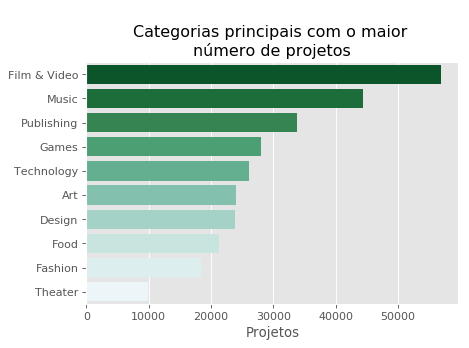

In [17]:
#Ploatndo um gráfico com as categorias principais com mais projetos:
fig = plt.figure(dpi=80)
ax  = sns.barplot(x = Top_Main_categories.values, y = Top_Main_categories.index, palette="BuGn_r", data = df)
plt.xlabel("Projetos")
plt.title("\nCategorias principais com o maior \nnúmero de projetos")
plt.show()

É possivel concluir que entre as categorias principais filme e video está em primeiro lugar e com uma boa margem, seguida de musica e publicações.

### Análise das categorias mais recorrentes:

In [18]:
#Encontrando as 10 categorias com maior número de projetos:
Top_categories = df.category.value_counts().head(10)

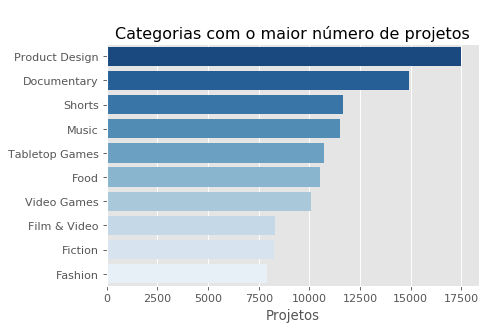

In [19]:
#Ploatndo um gráfico com as categorias principais com mais projetos:
fig = plt.figure(dpi = 80)
ax  = sns.barplot(x = Top_categories.values, y = Top_categories.index, palette="Blues_r", data = df)
plt.xlabel("Projetos")
plt.title("\nCategorias com o maior número de projetos")
plt.show()

### Análise da taxa de sucesso entre as categorias principais:

In [39]:
Top_Main_categories = dict(Top_Main_categories)

#calculando porcentagem de projetos que atingiram a meta por categoria:
def calcula_prob(categoria):
    return len(df[(df.main_category==categoria)&(df.state == "successful")])/len(df[(df.main_category == categoria)])

#criando listas para atribuir os valores da porcentagem dos projetos bem sucedidos:
probcat=[]
porcat =[]

#Atribuindo os nomes das categorias a uma variável em forma de lista:
nome_cat = list(Top_Main_categories.keys())

In [40]:
#Criando um loop para atribuir os valores da porcentagem na lista:
for i in Top_Main_categories:
    probcat.append(calcula_prob(i))

for e in probcat:
    porcat.append(e*100)

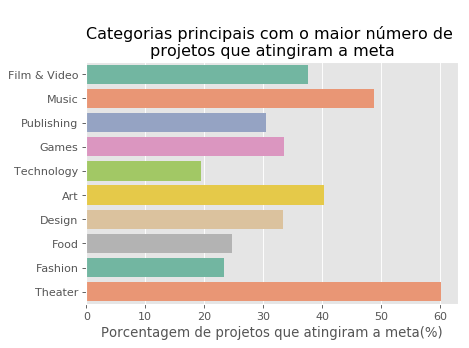

In [41]:
#Plotando o gráfico da porcentagem de sucesso para cada categoria principal:
fig = plt.figure(dpi=80)
ax  = sns.barplot(x = porcat, y = nome_cat,palette= "Set2", data = df)
plt.xlabel("Porcentagem de projetos que atingiram a meta(%)")
plt.title("\nCategorias principais com o maior número de \nprojetos que atingiram a meta")
plt.show()

### Análise dos paises de maior número de projetos

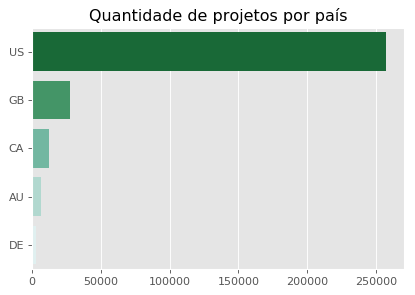

In [21]:
Top_Country = df.country.value_counts().head(5)
fig = plt.figure(dpi = 80)
ax  = sns.barplot(x = Top_Country.values, y = Top_Country.index, palette="BuGn_r", data = df);
plt.title("Quantidade de projetos por país")
plt.show()

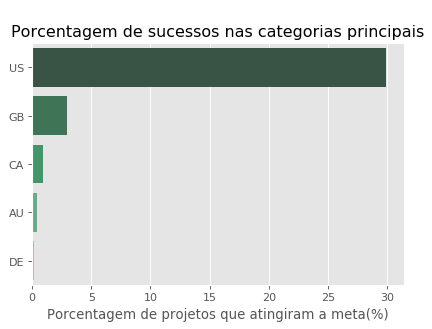

In [22]:

#################################
 #                               #
  #             Rever             #
 #                               #
#################################

Top_Country = dict(Top_Country)

#calculando porcentagem de projetos que atingiram a meta por categoria:
def calcula_prob(country):
    return len(df[(df.country==country)&(df.state == "successful")])/len(df.country)

probcountry=[]
for i in Top_Country:
    probcountry.append(calcula_prob(i))

nome_cat = list(Top_Country.keys())

porcat=[]

for e in probcountry:
    porcat.append(e*100)

fig = plt.figure(dpi=80)
ax  = sns.barplot(x = porcat, y = nome_cat, palette="BuGn_d", data = df)
plt.xlabel("Porcentagem de projetos que atingiram a meta(%)")
plt.title("\nPorcentagem de sucessos nas categorias principais")
plt.show()

### Análise da quantidade de apoiadores dos projetos:

### Análise das datas :

In [23]:
ddf["deadline"] = pd.to_datetime(df["deadline"], errors='coerce')
ddf["launched"] = pd.to_datetime(df["launched"], errors='coerce')
lista = ddf.deadline.tolist()
lista2= ddf.launched.tolist()
lista_dia_abertura=[]
lista_mes_abertura=[]
lista_ano_abertura=[]
lista_dia_encerramento=[]
lista_mes_encerramento=[]
lista_ano_encerramento=[]
lista_duracao=[]

for e in lista2:
    lista_dia_abertura.append(e.day)
    lista_mes_abertura.append(e.month)
    lista_ano_abertura.append(e.year)


for e in lista:
    lista_dia_encerramento.append(e.day)
    lista_mes_encerramento.append(e.month)
    lista_ano_encerramento.append(e.year)
    
ddf["Dia de abertura"]=lista_dia_abertura
ddf["Mês de abertura"]=lista_mes_abertura
ddf["Ano de abertura"]=lista_ano_abertura    
ddf['Dia de encerramento']=lista_dia_encerramento
ddf["Mês de encerramento"]=lista_mes_encerramento
ddf["Ano de encerramento"]=lista_ano_encerramento

for e in range(len(lista)):
    lista_duracao.append(lista[e]-lista2[e])


ddf["Duração da Arrecadação"]=lista_duracao
ddf["Duração da Arrecadação"] = pd.to_numeric(ddf["Duração da Arrecadação"], errors='coerce')
ddf = ddf.drop(columns=['deadline','launched'])
ddf = ddf.dropna( axis=0, subset=["Dia de abertura","Mês de abertura","Ano de abertura",'Dia de encerramento',"Mês de encerramento","Ano de encerramento","Duração da Arrecadação"])

dff = ddf.drop(columns=['state_successful','state_canceled','state_failed','state_live','state_suspended'])

,category_ A Faerie's Tale.,category_ 'As The World Collapses',category_ 'But it's my Birthday!' Edinburgh Fringe 2013,category_ 'Night Into Day' (Canceled),category_ 'Take Me Away' ... Become a part of Team Kerrin!,category_ (An American Opera ),category_ (Canceled),category_ 1st Birthday Celebration!,category_ 2 NEW Music Videos (one fan voted),category_ 2 full length CDs!,...,goal,backers,pledged,Dia de abertura,Mês de abertura,Ano de abertura,Dia de encerramento,Mês de encerramento,Ano de encerramento,Duração da Arrecadação
0,0,0,0,0,0,0,0,0,0,0,...,1000,0,0,11.0,8.0,2015.0,9.0,10.0,2015.0,5095412000000000


### implementando o classificador:

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(dff, ddf['state_successful'], test_size = 0.3, random_state = 100)                           
                           
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, 
                               max_depth=8, min_samples_leaf=4)
clf_gini.fit(X_train, y_train)   

y_pred = clf_gini.predict(X_test)

acc = accuracy_score(y_test, y_pred)

acc = acc*100
print("A acurácia é de {:.2f}%".format(acc))

A acurácia é de 99.17%


### Implementando o RandomForest:

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

X_train, X_test, y_train, y_test = train_test_split(dff, ddf['state_successful'], test_size=0.33, random_state=RANDOM_SEED)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

x_logistica = np.linspace(-10, 10, 500)
y_logistica = 1/(1 + np.exp(-x_logistica))

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Acurácia: {}'.format(accuracy_score(y_test, y_pred)))

Acurácia: 0.962638906023136


## Referências:

- 
- 
- 